# Beispiel Qualitätstest ohne unittest-Framework
In diesem Notebook wird ein Test gezeigt, bei dem nicht auf das unittest-Framework zurückgegriffen wird. Der Test ist sehr ausführlich und entsprechend kommentiert, da er instruktiven Charakter haben soll.

In [1]:
import ifcopenshell
from ifcopenshell.api import run
import ifcopenshell.util.element
import ifcopenshell.util.selector
import re
import os
from collections import Counter

# imports for computing geometry
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import griddata, LinearNDInterpolator

import matplotlib.pyplot as plt

In [2]:
# Laden der IFC-Datei.
model = ifcopenshell.open("../project_data/script_output_4x3.ifc")
model = ifcopenshell.open("../project_data/script_output_4x3_with_errors.ifc")

In [3]:
def Modellaufbau_Borehole_GeotechnicalStratum(model):
    """
    Beschreibung:
        Ein IfcBorehole dient als Container für verschiedene IfcGeotechnicalStratum. IfcBorehole beschreibt die Bohrung als ganzes, wohin IfcGeotechnicalStratum zur Repräsentation von Ansprachebereichen verwendet wird.
    Anweisung:
        Der Modellaufbau ist durch den Fachplaner für Geotechnik sicherzustellen.
    """

    # Filtern der Elemente
    elems = model.by_type("IfcGeotechnicalStratum")
    elems = [i for i in elems if i.ObjectType == "ANSPRACHEBEREICH"]
    
    # Alternativ unter Nutzung der Query Syntax
    elems = ifcopenshell.util.selector.filter_elements(model, "IfcGeotechnicalStratum, ObjectType=ANSPRACHEBEREICH")

    # Für jedes Element: Prüfen der Anforderung
    passed, failed = [], []
    for elem in elems:
        if not elem.Decomposes:
            failed.append(elem)
            continue
        if any((i.RelatingObject.is_a("IfcBorehole") and i.is_a("IfcRelAggregates")) for i in elem.Decomposes): # Hinweis: Hier muss minndestens eine der IfcRelAggregates auf ein IfcBorehole verweisen. Wenn es genau eins sein soll, dann len(elem.Decomposes) == 1 und elem.Decomposes[0] testen
            passed.append(elem)
        else:
            failed.append(elem)
    
    print(f"{len(passed)} Elemente haben bestanden, {len(failed)} sind durchgefallen.")
    if failed:
        print(f"Durchgefallen sind:\n")
        for i in failed:
            print(f"\t{failed}")

    return passed, failed

Modellaufbau_Borehole_GeotechnicalStratum(model)    
pass

15 Elemente haben bestanden, 1 sind durchgefallen.
Durchgefallen sind:

	[#70988=IfcGeotechnicalStratum('0GuPFJDhT71uSXvyaZowHd',$,'wrong_borehole_name_xy',$,'ANSPRACHEBEREICH',$,$,$,.USERDEFINED.)]


In [4]:
# Each IfcBorehole shall have the Pset_BoreholeCommon
elems = model.by_type("IfcBorehole")
passed, failed = [], []
for elem in elems:
    psets = ifcopenshell.util.element.get_psets(elem)
    if "Pset_BoreholeCommon" in ifcopenshell.util.element.get_psets(elem).keys():
        passed.append(elem)
    else:
        failed.append(elem)

In [5]:
# Get the containers for each IfcBorehole
elems = model.by_type("IfcBorehole")
passed, failed = [], []
for elem in elems:
    container = ifcopenshell.util.element.get_container(elem)
    if container:
        print(f"The Borehole {elem.Name} is located in {container.Name}, {container}")
    else:
        print(f"No container for {elem.Name}")

The Borehole bh_001 is located in Baustelle_Fachsektionstage, #26=IfcSite('01vgdV5lD3MvvLd69lykev',$,'Baustelle_Fachsektionstage',$,$,$,$,$,$,$,$,$,$,$)
The Borehole bh_002 is located in Baustelle_Fachsektionstage, #26=IfcSite('01vgdV5lD3MvvLd69lykev',$,'Baustelle_Fachsektionstage',$,$,$,$,$,$,$,$,$,$,$)
The Borehole bh_003 is located in Baustelle_Fachsektionstage, #26=IfcSite('01vgdV5lD3MvvLd69lykev',$,'Baustelle_Fachsektionstage',$,$,$,$,$,$,$,$,$,$,$)
The Borehole bh_004 is located in Baustelle_Fachsektionstage, #26=IfcSite('01vgdV5lD3MvvLd69lykev',$,'Baustelle_Fachsektionstage',$,$,$,$,$,$,$,$,$,$,$)
The Borehole bh_005 is located in Baustelle_Fachsektionstage, #26=IfcSite('01vgdV5lD3MvvLd69lykev',$,'Baustelle_Fachsektionstage',$,$,$,$,$,$,$,$,$,$,$)
No container for wrong_borehole_name
No container for wrong_borehole_name


In [6]:
# Check naming convention
elems = model.by_type("IfcBorehole")
passed, failed = [], []
for elem in elems:
    if re.match( r'^bh_\d{3}$', elem.Name):
        passed.append(elem)
    else:
        failed.append(elem)

In [7]:
# Unique Names in boreholes
elems =model.by_type("IfcBorehole")
counter = Counter([i.Name for i in model.by_type("IfcBorehole")])
passed, failed = [], []
for elem in elems:
    if counter[elem.Name]==1:
        passed.append(elem.Name)
    else:
        failed.append(elem.Name)

In [8]:
# Naming convention Ansprachebereiche
elems =model.by_type("IfcGeotechnicalStratum")
elems = [i for i in elems if i.ObjectType=="ANSPRACHEBEREICH"]
passed, failed = [], []
for elem in elems:
    name = elem.Name
    if not elem.Decomposes:
        failed.append(elem)
        continue
    if not any((i.RelatingObject.is_a("IfcBorehole") and i.is_a("IfcRelAggregates")) for i in elem.Decomposes):
        failed.append(elem)
        continue
    for i in elem.Decomposes:
        if (i.RelatingObject.is_a("IfcBorehole") and i.is_a("IfcRelAggregates")):
            bh_name = i.RelatingObject.Name
            if re.match(fr'^{re.escape(bh_name)}_\d{{3}}$', elem.Name):
                passed.append(elem)
            else:
                failed.append(elem)
            break

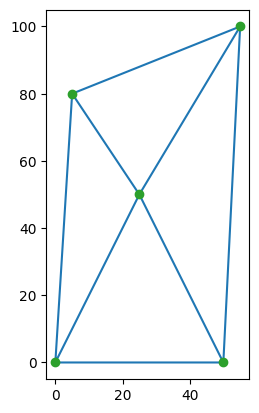

[[0 1]
 [0 2]
 [0 4]
 [1 2]
 [1 3]
 [2 3]
 [2 4]
 [3 4]] [ 50.          55.90169944  80.15609771  55.90169944 100.12492197
  58.30951895  36.05551275  53.85164807]


C:\Users\Windows\AppData\Local\Temp\ipykernel_14208\3053374664.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(ansatzpunkte[:,0],ansatzpunkte[:,1], cmap="viridis", c="black")


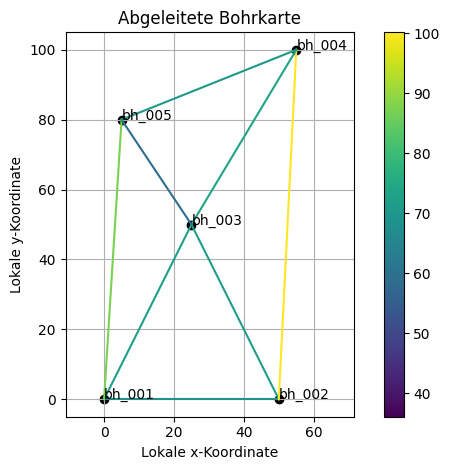

In [9]:
# Check distances of boreholes
elems =model.by_type("IfcBorehole")

ansatzpunkte, bh_names = [], []
for i in elems:
    parts =  i.IsDecomposedBy
    points_per_borehole = []
    if not parts:
        continue
    for j in parts:
        stratums = j.RelatedObjects
        for k in stratums:
            placement = k.ObjectPlacement
            rel_to = placement.PlacementRelTo
            #print(placement.PlacementRelTo)
            #print(placement.RelativePlacement.Location.Coordinates)
            
            c1 = placement.PlacementRelTo.RelativePlacement.Location.Coordinates
            c2 = placement.RelativePlacement.Location.Coordinates
            c3 = (c1[0]+c2[0], c1[1]+c2[1], c1[2]+c2[2])  # das sind die unterkanten
            

            representations = k.Representation.Representations
            representation = [i for i in representations if i.ContextOfItems.ContextIdentifier=="Body"][0]
            # The geometry of a borehole thing only consists 
            if len(representation.Items)!=1:
                raise ValueError(f"To many geometries assigned. Expected 1, got {len(representation.Items)}")
            geom = representation.Items[0]
            # c4 sind nun die oberkanten der Bohrungen
            c4 = (c3[0] + geom.ExtrudedDirection.DirectionRatios[0] * geom.Depth,
                  c3[1] + geom.ExtrudedDirection.DirectionRatios[1] * geom.Depth,
                  c3[2] + geom.ExtrudedDirection.DirectionRatios[2] * geom.Depth)
           
            # We know that it is a swept solid. Position is here set to (0,0,0) but for reference
            if not geom.is_a("IfcExtrudedAreaSolid"):
                raise ValueError(f"Expected an IfcExtrudedAreaSolid")
            position = geom.Position.Location.Coordinates
            c5 = (c4[0]+position[0], c4[1]+position[1], c4[2]+position[2])
            points_per_borehole.append(c5)
    ansatzpunkt = sorted(points_per_borehole, key = lambda x : x[2], reverse=True)[0]
    ansatzpunkte.append(ansatzpunkt)
    bh_names.append(i.Name)

ansatzpunkte_3d = np.array([[i[0], i[1], i[2]] for i in ansatzpunkte]) 
ansatzpunkte =np.array([[i[0], i[1]] for i in ansatzpunkte]) # nur xy-Koordinaten
triangulation = Delaunay(ansatzpunkte)

plt.triplot(ansatzpunkte[:,0], ansatzpunkte[:,1], triangulation.simplices)
plt.plot(ansatzpunkte[:,0], ansatzpunkte[:,1], 'o')
plt.gca().set_aspect("equal")
plt.show()


edges, lengths = [], []
def less_first(a, b):
    return [a,b] if a < b else [b,a]
for triangle in triangulation.simplices:
    for e1, e2 in [[0,1],[1,2],[2,0]]: # for all edges of triangle
        edges.append(less_first(triangle[e1],triangle[e2]))
array_of_edges = np.unique(edges, axis=0)

for p1,p2 in array_of_edges:
    x1, y1 = triangulation.points[p1]
    x2, y2 = triangulation.points[p2]
    lengths.append((x1-x2)**2 + (y1-y2)**2)
array_of_lengths = np.sqrt(np.array(lengths))


print(array_of_edges, array_of_lengths)

fig, ax = plt.subplots()

#xi,yi = np.meshgrid([i[0] for i in topograhy_coords], [i[1] for i in topograhy_coords])
#zi = griddata(([i[0] for i in topograhy_coords], [i[1] for i in topograhy_coords]), [i[2] for i in topograhy_coords], (xi, yi), method="linear")
#ax.contourf(xi,yi,zi, cmap="Grays", alpha=0.3)
#ax.contour(xi,yi,zi,levels=10)

scatter = ax.scatter(ansatzpunkte[:,0],ansatzpunkte[:,1], cmap="viridis", c="black")
scatter.set_clim(min(array_of_lengths), max(array_of_lengths))
for ind, bh_name in enumerate(bh_names):
    ax.annotate(bh_name, (ansatzpunkte[ind,0],ansatzpunkte[ind,1]))

for ind, (p1,p2) in enumerate(array_of_edges):
    x1,y1 = ansatzpunkte[p1]
    x2,y2 = ansatzpunkte[p2]
    ax.plot([x1,x2],[y1,y2], color=plt.cm.viridis(array_of_lengths[ind]/np.max(array_of_lengths)))


ax.set_xlim(np.min(ansatzpunkte[:,0]) -  0.2 * (np.max(ansatzpunkte[:,0]- np.min(ansatzpunkte[:,0]))),
            np.max(ansatzpunkte[:,0] + 0.3 * (np.max(ansatzpunkte[:,0]- np.min(ansatzpunkte[:,0])))))
ax.set_aspect("equal")
ax.set_xlabel("Lokale x-Koordinate")
ax.set_ylabel("Lokale y-Koordinate")
ax.set_title("Abgeleitete Bohrkarte")
ax.grid()
fig.colorbar(scatter)
fig.tight_layout()


In [10]:
# Check correct type of modelling
elems = model.by_type("IfcBorehole")


update = False
passed, failed = [], []
for elem in elems:
    parts = elem.IsDecomposedBy
    points_per_borehole = []
    if not parts:
        continue
    for j in parts:
        stratums = j.RelatedObjects
        for k in stratums:
            placement = k.ObjectPlacement
            rel_to = placement.PlacementRelTo
            c1 = placement.PlacementRelTo.RelativePlacement.Location.Coordinates
            c2 = placement.RelativePlacement.Location.Coordinates
            c3 = (c1[0]+c2[0], c1[1]+c2[1], c1[2]+c2[2])  
            representations = k.Representation.Representations
            representation = [i for i in representations if i.ContextOfItems.ContextIdentifier=="Body"][0]

            if representation.RepresentationType == "SweptSolid":
                pass
                #print(representation.RepresentationType)
            
            if len(representation.Items)!=1:
                failed.append(elem)
            else:
                item = representation.Items[0]
                sweptarea = item.SweptArea
                print(sweptarea)
                if sweptarea.is_a("IfcCircleProfileDef"):
                    if (sweptarea.Radius)==1.0:
                        passed.append(elem)
                    else:
                        if update:
                            sweptarea.Radius=1.0
                            passed.append(elem)
                        else:
                            failed.append(elem)
                else:
                    failed.append(elem)


if update:
    model.write("../project_data/script_output_4x3_with_errors.ifc")

#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)
#54=IfcCircleProfileDef(.AREA.,'300C',$,0.3)


In [11]:
# Check distance to topography
topograhy = model.by_type("IfcGeographicElement")
topograhy = [i for i in topograhy if i.PredefinedType=="TERRAIN"][0]
rep = topograhy.Representation.Representations[0].Items[0]
topograhy_coords = rep.Coordinates.CoordList
topograhy_coords_2d = [[i[0], i[1]] for i in topograhy_coords]

elems = model.by_type("IfcBorehole")

passed, failed = [], []
for elem in elems:
    parts = elem.IsDecomposedBy
    points_per_borehole = []
    if not parts:
        continue
    for j in parts:
        stratums = j.RelatedObjects
        for k in stratums:
            placement = k.ObjectPlacement
            rel_to = placement.PlacementRelTo
            c1 = placement.PlacementRelTo.RelativePlacement.Location.Coordinates
            c2 = placement.RelativePlacement.Location.Coordinates
            c3 = (c1[0]+c2[0], c1[1]+c2[1], c1[2]+c2[2])  
            representations = k.Representation.Representations
            representation = [i for i in representations if i.ContextOfItems.ContextIdentifier=="Body"][0]

            if len(representation.Items)!=1:
                raise ValueError(f"To many geometries assigned. Expected 1, got {len(representation.Items)}")
            geom = representation.Items[0]

            c4 = (c3[0] + geom.ExtrudedDirection.DirectionRatios[0] * geom.Depth,
                  c3[1] + geom.ExtrudedDirection.DirectionRatios[1] * geom.Depth,
                  c3[2] + geom.ExtrudedDirection.DirectionRatios[2] * geom.Depth)

            if not geom.is_a("IfcExtrudedAreaSolid"):
                raise ValueError(f"Expected an IfcExtrudedAreaSolid")
            position = geom.Position.Location.Coordinates
            c5 = (c4[0]+position[0], c4[1]+position[1], c4[2]+position[2])
            points_per_borehole.append(c5)
    ansatzpunkt = sorted(points_per_borehole, key = lambda x : x[2], reverse=True)[0]
    
    # Using the nearest point of the topography
    distances = np.linalg.norm(topograhy_coords_2d - np.array([ansatzpunkt[0],ansatzpunkt[1]]), axis=1)
    closest_index = np.argmin(distances)
    delta = np.abs(ansatzpunkt[2] - topograhy_coords[closest_index][2])

    # Using the actual topography.
    interpolator = LinearNDInterpolator(topograhy_coords_2d, [i[2] for i in topograhy_coords])
    z_val_new = interpolator(ansatzpunkt[0],ansatzpunkt[1])
    delta = np.abs(ansatzpunkt[2] - z_val_new)

    if delta<0.5:
        passed.append(elem)
    else:
        failed.append(elem)


In [12]:
def WerteBereich_Kohaesion(model, min_val=0, max_val=1_000):
    """
    X.	Werte für die CohesionBehaviour im Propertyset Pset_SolidStratumCapacity liegen im Intervall zwischen 0 und 1000 kN/m².
    """
    # Filtern der Elemente
    # Hinweis: IfcSimpleProperties können auf mehrere Arten beschrieben werden, die am häufigst verwendete ist IfcPropertySingleValue
    elems = model.by_type("IfcSimpleProperty")
    #elems = model.by_type("IfcPropertySingleValue") + model.by_type("IfcPropertyBoundedValue") + model.by_type("IfcPropertyEnumeratedValue") + model.by_type("IfcPropertyListValue") + model.by_type("IfcPropertyReferenceValue") + model.by_type("IfcPropertyTableValue")

    elems = [i for i in elems if i.Name=="CohesionBehaviour"]
    elems = [i for i in elems if any(j.Name=="Pset_SolidStratumCapacity" for j in i.PartOfPset)]

    # Für jedes Element: Prüfen der Anforderung
    passed, failed = [], []
    for elem in elems:
        value = elem.NominalValue.wrappedValue
        if value>=min_val and value<=max_val: # Hinweis: Im IDS Beispiel werden die beiden Tests gesondert gelistet.
            passed.append(elem)
        else:
            failed.append(elem)

    #    print(elem.NominalValue, elem.Unit)
    #    print(elem.HasConstraints)
    #print(dir(elem.NominalValue))
    #print(elem.NominalValue.wrappedValue)


WerteBereich_Kohaesion(model)

In [13]:
def Reibungswinkel_Sand(model):
    """Reibungswinkel für Sande muss zwischen 27.5 und """
    elems = model.by_type("IfcGeotechnicalStratum")
    elems = [i for i in elems if i.PredefinedType=="SOLID"]

    material_filter = [[j.RelatingMaterial for j in i.HasAssociations if j.RelatingMaterial.Name=="Sand"] for i in elems]
    elems = [i for ind, i in enumerate(elems) if material_filter[ind] ]

    for elem in elems:
        psets = ifcopenshell.util.element.get_psets(elem)
        if "Pset_SolidStratumCapacity" in psets.keys():
            pset = psets["Pset_SolidStratumCapacity"]
            if "FrictionAngle" in pset.keys():
                friction_angle = pset["FrictionAngle"]
                print(friction_angle)


Reibungswinkel_Sand(model)

elems = [i for i in model.by_type("IfcSimpleProperty") if i.Name == "FrictionAngle"]
elems = [i for i in elems if any([j for j in i.PartOfPset if j.Name=="Pset_SolidStratumCapacity"])]
for elem in elems:
    
    # test if any of the parent objects has the material "Sand"
    is_related_to_a_sand = False
    for pset in elem.PartOfPset:
        for rel in pset.DefinesOccurrence:
            for parent_obj in rel.RelatedObjects:
                for association in parent_obj.HasAssociations:
                    if association.RelatingMaterial.Name=="Sand":
                        is_related_to_a_sand = True
    if not is_related_to_a_sand:
        continue
    
    val = elem.NominalValue
    is_degrees = False
    if elem.Unit == None:
        # get the unit for PLANEANGLEUNIT
        global_unit_assignments = model.by_type("IfcUnitAssignment")
        unit = [[j for j in i.Units] for i in global_unit_assignments]
        for i in global_unit_assignments:
            for j in i.Units:
                if hasattr(j, "UnitType"):
                    if j.UnitType=="PLANEANGLEUNIT":
                        if "DEGREE" in j.Name.upper():
                            is_degrees = True
    else:
        if "DEGREE" in elem.Unit.Name.upper():
            is_degrees = True

    print(val, elem.Unit, val.wrappedValue)

32.5
IfcPlaneAngleMeasure(32.5) None 32.5


In [14]:
def material_colors(model):
    """Farben der Maaterialen für die Materialien"""
    elems = model.by_type("IfcGeotechnicalStratum")
    elems = [i for i in elems if i.PredefinedType=="SOLID"]

    colors_DIN4023 = {"Kies":  (219, 171, 6), "Sand": (198, 84, 47), "Auffuellung": (127, 127, 127)}

    passed, failed = [], []
    for elem in elems:
        # ifcopenshell.util.element.get_material(elem) would be an alternative
        for relAssociatesMaterial in elem.HasAssociations:
            mat = relAssociatesMaterial.RelatingMaterial
            representations = mat.HasRepresentation

            for representation in representations:
                for style_rep in representation.Representations:
                    for i in style_rep.Items:
                        for style in i.Styles:
                            for style2 in style.Styles:
                                color= style2.SurfaceColour
                                rgb = (int(round(255*color.Red,0)), int(round(255*color.Green,0)), int(round(255*color.Blue,0)))
                                print(f"Baugrundschicht {elem.Name} has the Material {mat.Name}, that is styled with the color {rgb} {color}.")
                                
                                if colors_DIN4023[mat.Name] == rgb:
                                    passed.append(relAssociatesMaterial)
                                else:
                                    failed.append(relAssociatesMaterial)

material_colors(model)


Baugrundschicht S has the Material Sand, that is styled with the color (198, 84, 47) #50=IfcColourRgb('SandStyle',0.776470588235294,0.329411764705882,0.184313725490196).
Baugrundschicht A has the Material Auffuellung, that is styled with the color (127, 127, 127) #36=IfcColourRgb('AuffuellungStyle',0.498039215686275,0.498039215686275,0.498039215686275).
Baugrundschicht G has the Material Kies, that is styled with the color (219, 171, 6) #43=IfcColourRgb('KiesStyle',0.858823529411765,0.670588235294118,0.0235294117647059).


In [31]:
elems = model.by_type("IfcPropertySet")
elems = [i for i in elems if i.Name=="Fachsektionstage2025"]
for elem in elems:
    pass
print(elem.HasProperties)

(#70984=IfcPropertySingleValue('WichteFeucht',$,IfcMassDensityMeasure(19000.),#18), #70985=IfcPropertySingleValue('IsRelevant',$,IfcBoolean(.T.),$), #70986=IfcPropertyBoundedValue('WichteUnterAuftrieb',$,IfcMassDensityMeasure(30.),IfcMassDensityMeasure(0.),#12,IfcMassDensityMeasure(19.8)))


In [16]:
def check_units(model):
    """Einhteiten der Wichten prüfen"""
    
    elems = model.by_type("IfcSimpleProperty")
    elems = [i for i in elems if any(j in i.Name for j in ["WichteUnterAuftrieb", "WichteFeucht"])]
    failed, passed = [], []
    for elem in elems:
        #print(f"{elem.Name} of type {elem.is_a()} has the unit {elem.Unit}")
        passed1, passed2 = False, False

        unit = elem.Unit
        if unit.is_a() != "IfcDerivedUnit":
            print("Expected a IfcDerivedUnit")
        
        if unit.UnitType!="MASSDENSITYUNIT":
            print("Expected a MASSDENSITYUNIT")
        
        for derivedunitelem in unit.Elements:
            derivedunitelem_unit = derivedunitelem.Unit
            if derivedunitelem_unit.UnitType == "LENGTHUNIT":
                if derivedunitelem.Exponent!=(-3):
                    raise ValueError("Expected exponent -3 for the lengthunit")
                if derivedunitelem_unit.is_a("IfcSIUnit"):
                    if derivedunitelem_unit.Prefix==None:
                        passed1=True
            elif derivedunitelem_unit.UnitType == "MASSUNIT":
                if derivedunitelem.Exponent!=1:
                    raise ValueError("Expected exponent 1 for the massunit")
                if derivedunitelem_unit.is_a("IfcSIUnit"):
                    if derivedunitelem_unit.Prefix=="KILO":
                        passed2=True
            else:
                raise ValueError(f"Unexpected UnitType. Must be eiter LENGTHUNIT or MASSUNIT, but it {derivedunitelem.UnitType}")
            #print(derivedunitelem_unit.UnitType, dir(derivedunitelem_unit))
            
            if passed1 and passed2:
                passed.append(elem)
            else:
                failed.append(elem)


check_units(model)


In [17]:
def val_in_bounds(model):
    """Nominalwerte in BoundendValues müssen innerhalb der Grenzen liegen."""
    elems = model.by_type("IfcPropertyBoundedValue")
    passed, failed = [], []
    for elem in elems:
        lower = elem.LowerBoundValue
        upper = elem.UpperBoundValue
        nominal = elem.SetPointValue
        print(f"Is: {nominal}, lower Bound: {lower}, upper Bound: {upper}, Unit is: {elem.Unit}")
        if nominal.wrappedValue<=upper.wrappedValue and nominal.wrappedValue>=lower.wrappedValue:
            passed.append(elem)
        else:
            failed.append(failed)

val_in_bounds(model)


Is: IfcMassDensityMeasure(19.8), lower Bound: IfcMassDensityMeasure(0.), upper Bound: IfcMassDensityMeasure(30.), Unit is: #12=IfcDerivedUnit((#10,#11),.MASSDENSITYUNIT.,$,'kg_per_m3')
Is: IfcMassDensityMeasure(19.8), lower Bound: IfcMassDensityMeasure(0.), upper Bound: IfcMassDensityMeasure(30.), Unit is: #12=IfcDerivedUnit((#10,#11),.MASSDENSITYUNIT.,$,'kg_per_m3')
Is: IfcMassDensityMeasure(19.8), lower Bound: IfcMassDensityMeasure(0.), upper Bound: IfcMassDensityMeasure(30.), Unit is: #12=IfcDerivedUnit((#10,#11),.MASSDENSITYUNIT.,$,'kg_per_m3')


In [18]:
def file_size(filepath, max_size):
    file_size = os.stat(filepath).st_size
    file_size_mb = file_size / (1023 * 1024)
    
    if file_size_mb < max_size:
        return True
    else:
        return False

is_smaller_than_size = file_size("../project_data/script_output_4x3.ifc", max_size=10)
is_smaller_than_size

True

In [19]:
# Calculation using Blender see: https://github.com/IfcOpenShell/IfcOpenShell/blob/v0.7.0/src/blenderbim/blenderbim/bim/module/qto/helper.py
# Note: There is a function to validate quantities, see: https://docs.ifcopenshell.org/ifcopenshell/geometry_settings.html
def check_volume(model, use_rhinoinside=False):
    passed, failed = [], []
    tolerance = 0.01
    settings = ifcopenshell.geom.settings()
    elems = model.by_type("IfcGeotechnicalStratum")
    elems = [i for i in elems if i.PredefinedType=="SOLID"]
    for elem in elems:
        volume_qto=None
        psets =ifcopenshell.util.element.get_psets(elem)
        if "Qto_VolumetricStratumBaseQuantities" in psets.keys():
            qto = psets["Qto_VolumetricStratumBaseQuantities"]
            if "Volume" in qto.keys():
                volume_qto = qto["Volume"]
        if not volume_qto:
            continue
        shape = ifcopenshell.geom.create_shape(settings, elem)
        

        if use_rhinoinside:
            import rhinoinside
            rhinoinside.load()
            import System
            import Rhino
            ifc_verts =  [shape.geometry.verts[3*i:3*(i+1)] for i in range(int(len(shape.geometry.verts)/3))] #  range +1?
            ifc_faces = [shape.geometry.faces[3*i:3*(i+1)] for i in range(int(len(shape.geometry.faces)/3))]

            mesh = Rhino.Geometry.Mesh()
            verts = mesh.Vertices
            faces = mesh.Faces
            for v in ifc_verts:
                verts.Add(v[0], v[1], v[2])
            for f in ifc_faces:
                faces.AddFace(f[0], f[1], f[2])
            mesh.Normals.ComputeNormals()

            volume_calc = mesh.Volume()
            #print(f"Rhino: Mesh has the Volume {volume}, is closd {mesh.IsClosed}, is valid {mesh.IsValid}")
        else:
            volume_calc = ifcopenshell.util.shape.get_volume(shape.geometry)
            
        if abs(volume_calc-volume_qto)<tolerance:
            passed.append(elem)
        else:
            failed.append(elem)
    
check_volume(model, use_rhinoinside=False)

In [ ]:
# Get the soil volume for sand and modify it
elem = [i for i in model.by_type("IfcGeotechnicalStratum") if (i.Name == "S" and i.PredefinedType=="SOLID")][0]

print(f"ELEMENT TO MODIFY: {elem}")

# MODIFY THE UNIT OF THE WICHTE UNTER AUFTRIEB
psets = model.by_type("IfcPropertySet")
psets = [i for i in psets if i.Name=="Fachsektionstage2025"]
for pset in psets:
    for rel in pset.DefinesOccurrence:
        for parent_obj in rel.RelatedObjects:
            if parent_obj == elem:
                final_pset = pset
                #print("PSET FOUND", pset, "\n", "\t", parent_obj,"\n", "\t",  elem,)
                break
        if final_pset: break
    if final_pset: break
properties = final_pset.HasProperties
wichte_unter_auftrieb = [i for i in properties if i.Name=="WichteUnterAuftrieb"][0]
wichte_unter_auftrieb.Unit = None


# MODIFY THE VALUE OF THE COHESION AND THE FRICTION ANGLE
psets = model.by_type("IfcPropertySet")
psets = [i for i in psets if i.Name=="Pset_SolidStratumCapacity"]
for pset in psets:
    for rel in pset.DefinesOccurrence:
        for parent_obj in rel.RelatedObjects:
            if parent_obj == elem:
                final_pset = pset
                #print("PSET FOUND", pset, "\n", "\t", parent_obj,"\n", "\t",  elem,)
                break
        if final_pset: break
    if final_pset: break
properties = final_pset.HasProperties
cohesion = [i for i in properties if i.Name=="CohesionBehaviour"][0]
cohesion.NominalValue = model.create_entity("IfcPressureMeasure", 1001)
friction_angle = [i for i in properties if i.Name=="FrictionAngle"][0]
friction_angle.NominalValue = model.create_entity("IfcPlaneAngleMeasure", 40.1)

# MODIFY THE VALUE OF THE VOLUME
qtos = model.by_type("IfcElementQuantity")

qtos = [i for i in qtos if i.Name=="Qto_VolumetricStratumBaseQuantities"]

for qto in qtos:
    for rel in pset.DefinesOccurrence:
        for parent_obj in rel.RelatedObjects:
            if parent_obj == elem:
                final_qto = qto
                print("QTO FOUND", qto, "\n", "\t", parent_obj,"\n", "\t",  elem,)
                break
        if final_qto: break
    if final_qto: break
quantities = final_qto.Quantities
volume = [i for i in quantities if i.Name=="Volume"][0]
volume.VolumeValue = 1000


# Change the material color.
        # ifcopenshell.util.element.get_material(elem) would be an alternative


for relAssociatesMaterial in elem.HasAssociations:
    mat = relAssociatesMaterial.RelatingMaterial
    representations = mat.HasRepresentation

    for representation in representations:
        for style_rep in representation.Representations:
            for i in style_rep.Items:
                for style in i.Styles:
                    for style2 in style.Styles:
                        color= style2.SurfaceColour
                        color.Red = 1
                        color.Green = 1 
                        color.Blue = 1




ELEMENT TO MODIFY: #12756=IfcGeotechnicalStratum('18fME8uurD5gs3s6TCzsgh',$,'S','A volume representing a subsoil layer.',$,$,#24393,$,.SOLID.)
QTO FOUND #70940=IfcElementQuantity('0Hx8KcnL146Aq6NOuI03bQ',$,'Qto_VolumetricStratumBaseQuantities',$,$,(#70942)) 
 	 #12756=IfcGeotechnicalStratum('18fME8uurD5gs3s6TCzsgh',$,'S','A volume representing a subsoil layer.',$,$,#24393,$,.SOLID.) 
 	 #12756=IfcGeotechnicalStratum('18fME8uurD5gs3s6TCzsgh',$,'S','A volume representing a subsoil layer.',$,$,#24393,$,.SOLID.)
#50=IfcColourRgb('SandStyle',0.776470588235294,0.329411764705882,0.184313725490196)
